In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="f4hZty0TCNFmrw4fgsoL")
project = rf.workspace("siabar").project("ppe-dataset-for-workplace-safety")
version = project.version(2)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PPE-Dataset-for-Workplace-Safety-2 in coco:: 100%|██████████| 1621/1621 [00:00<00:00, 3591.41it/s]


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ex0fwaev
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ex0fwaev
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [02/15 19:52:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/15 19:52:03 d2.data.datasets.coco]: Loaded 1126 images in COCO format from /content/train/_annotations.coco.json


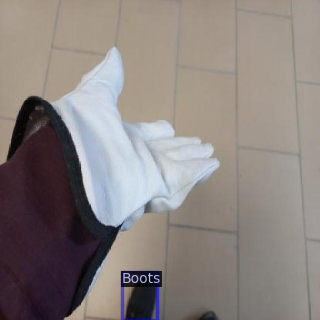

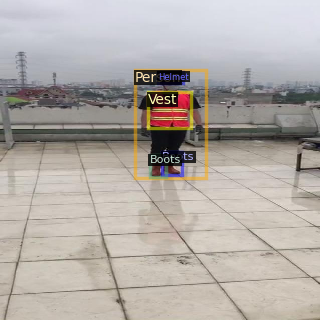

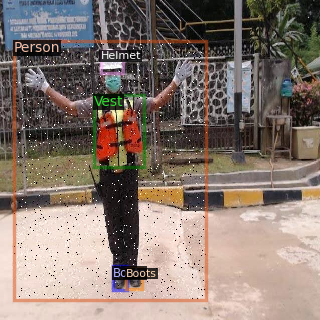

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [6]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [7]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1300)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/15 19:52:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
model_final_68b088.pkl: 421MB [00:01, 235MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/15 19:52:12 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[02/15 19:52:51 d2.utils.events]:  eta: 0:42:20  iter: 19  total_loss: 3.492  loss_cls: 2.32  loss_box_reg: 0.8307  loss_rpn_cls: 0.3055  loss_rpn_loc: 0.03101    time: 1.7524  last_time: 1.7409  data_time: 0.0442  last_data_time: 0.0449   lr: 1.931e-06  max_mem: 6878M
[02/15 19:53:31 d2.utils.events]:  eta: 0:42:50  iter: 39  total_loss: 3.491  loss_cls: 2.294  loss_box_reg: 0.8234  loss_rpn_cls: 0.3516  loss_rpn_loc: 0.03413    time: 1.7865  last_time: 2.0131  data_time: 0.0234  last_data_time: 0.0298   lr: 2.911e-06  max_mem: 6878M
[02/15 19:54:09 d2.utils.events]:  eta: 0:43:42  iter: 59  total_loss: 3.362  loss_cls: 2.237  loss_box_reg: 0.8411  loss_rpn_cls: 0.2465  loss_rpn_loc: 0.02782    time: 1.8314  last_time: 2.1502  data_time: 0.0246  last_data_time: 0.0173   lr: 3.891e-06  max_mem: 6878M
[02/15 19:54:51 d2.utils.events]:  eta: 0:44:46  iter: 79  total_loss: 3.297  loss_cls: 2.169  loss_box_reg: 0.8248  loss_rpn_cls: 0.2728  loss_rpn_loc: 0.03029    time: 1.8937  last_time:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[02/15 20:09:00 d2.evaluation.evaluator]: Inference done 11/326. Dataloading: 0.0010 s/iter. Inference: 0.1899 s/iter. Eval: 0.0003 s/iter. Total: 0.1911 s/iter. ETA=0:01:00
[02/15 20:09:05 d2.evaluation.evaluator]: Inference done 37/326. Dataloading: 0.0037 s/iter. Inference: 0.1888 s/iter. Eval: 0.0004 s/iter. Total: 0.1930 s/iter. ETA=0:00:55
[02/15 20:09:10 d2.evaluation.evaluator]: Inference done 64/326. Dataloading: 0.0027 s/iter. Inference: 0.1886 s/iter. Eval: 0.0004 s/iter. Total: 0.1918 s/iter. ETA=0:00:50
[02/15 20:09:15 d2.evaluation.evaluator]: Inference done 90/326. Dataloading: 0.0028 s/iter. Inference: 0.1888 s/iter. Eval: 0.0004 s/iter. Total: 0.1921 s/iter. ETA=0:00:45
[02/15 20:09:20 d2.evaluation.evaluator]: Inference done 117/326. Dataloading: 0.0028 s/iter. Inference: 0.1886 s/iter. Eval: 0.0004 s/iter. Total: 0.1919 s/iter. ETA=0:00:40
[02/15 20:09:25 d2.evaluation.evaluator]: Inference done 144/326. Dataloading: 0.0026 s/iter. Inference: 0.1886 s/iter. Eval: 0.0

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[02/15 20:26:49 d2.evaluation.evaluator]: Inference done 11/326. Dataloading: 0.0050 s/iter. Inference: 0.1896 s/iter. Eval: 0.0005 s/iter. Total: 0.1951 s/iter. ETA=0:01:01
[02/15 20:26:54 d2.evaluation.evaluator]: Inference done 38/326. Dataloading: 0.0025 s/iter. Inference: 0.1890 s/iter. Eval: 0.0004 s/iter. Total: 0.1922 s/iter. ETA=0:00:55
[02/15 20:26:59 d2.evaluation.evaluator]: Inference done 65/326. Dataloading: 0.0021 s/iter. Inference: 0.1889 s/iter. Eval: 0.0004 s/iter. Total: 0.1916 s/iter. ETA=0:00:50
[02/15 20:27:04 d2.evaluation.evaluator]: Inference done 91/326. Dataloading: 0.0027 s/iter. Inference: 0.1890 s/iter. Eval: 0.0004 s/iter. Total: 0.1923 s/iter. ETA=0:00:45
[02/15 20:27:09 d2.evaluation.evaluator]: Inference done 118/326. Dataloading: 0.0025 s/iter. Inference: 0.1890 s/iter. Eval: 0.0004 s/iter. Total: 0.1921 s/iter. ETA=0:00:39
[02/15 20:27:14 d2.evaluation.evaluator]: Inference done 142/326. Dataloading: 0.0029 s/iter. Inference: 0.1889 s/iter. Eval: 0.0

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[02/15 20:44:46 d2.evaluation.evaluator]: Inference done 11/326. Dataloading: 0.0020 s/iter. Inference: 0.1873 s/iter. Eval: 0.0004 s/iter. Total: 0.1897 s/iter. ETA=0:00:59
[02/15 20:44:52 d2.evaluation.evaluator]: Inference done 38/326. Dataloading: 0.0029 s/iter. Inference: 0.1865 s/iter. Eval: 0.0003 s/iter. Total: 0.1900 s/iter. ETA=0:00:54
[02/15 20:44:57 d2.evaluation.evaluator]: Inference done 65/326. Dataloading: 0.0025 s/iter. Inference: 0.1872 s/iter. Eval: 0.0003 s/iter. Total: 0.1902 s/iter. ETA=0:00:49
[02/15 20:45:02 d2.evaluation.evaluator]: Inference done 91/326. Dataloading: 0.0032 s/iter. Inference: 0.1879 s/iter. Eval: 0.0003 s/iter. Total: 0.1916 s/iter. ETA=0:00:45
[02/15 20:45:07 d2.evaluation.evaluator]: Inference done 117/326. Dataloading: 0.0029 s/iter. Inference: 0.1887 s/iter. Eval: 0.0003 s/iter. Total: 0.1921 s/iter. ETA=0:00:40
[02/15 20:45:12 d2.evaluation.evaluator]: Inference done 143/326. Dataloading: 0.0027 s/iter. Inference: 0.1898 s/iter. Eval: 0.0

In [8]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[02/15 20:45:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [02/15 20:45:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [02/15 20:45:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/15 20:45:59 d2.data.datasets.coco]: Loaded 161 images in COCO format from /content/test/_annotations.coco.json
[02/15 20:45:59 d2.data.build]: Distribution of instances among all 9 categories:
|   category    | #instances   |  category  | #instances   |   category    | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
| Safety-Equi.. | 0            |   Boots    | 243          | Ear-protect.. | 0            |
|     Glass     | 0            |   Glove    | 0            |    Helmet     | 144          |
|     Mask      | 0            |   Person   | 138          |     Vest      | 191          |
|               |              |   

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[02/15 20:46:01 d2.evaluation.evaluator]: Inference done 11/161. Dataloading: 0.0069 s/iter. Inference: 0.1830 s/iter. Eval: 0.0005 s/iter. Total: 0.1905 s/iter. ETA=0:00:28
[02/15 20:46:06 d2.evaluation.evaluator]: Inference done 38/161. Dataloading: 0.0032 s/iter. Inference: 0.1847 s/iter. Eval: 0.0003 s/iter. Total: 0.1884 s/iter. ETA=0:00:23
[02/15 20:46:12 d2.evaluation.evaluator]: Inference done 65/161. Dataloading: 0.0026 s/iter. Inference: 0.1850 s/iter. Eval: 0.0003 s/iter. Total: 0.1881 s/iter. ETA=0:00:18
[02/15 20:46:17 d2.evaluation.evaluator]: Inference done 92/161. Dataloading: 0.0031 s/iter. Inference: 0.1857 s/iter. Eval: 0.0003 s/iter. Total: 0.1893 s/iter. ETA=0:00:13
[02/15 20:46:22 d2.evaluation.evaluator]: Inference done 119/161. Dataloading: 0.0029 s/iter. Inference: 0.1865 s/iter. Eval: 0.0003 s/iter. Total: 0.1898 s/iter. ETA=0:00:07
[02/15 20:46:27 d2.evaluation.evaluator]: Inference done 145/161. Dataloading: 0.0030 s/iter. Inference: 0.1873 s/iter. Eval: 0.0

OrderedDict([('bbox',
              {'AP': 55.204668479218114,
               'AP50': 86.84615604649794,
               'AP75': 61.73162400432061,
               'APs': 21.945367104901248,
               'APm': 55.05561074868951,
               'APl': 58.42304252537311,
               'AP-Safety-Equipment': nan,
               'AP-Boots': 50.47832059945067,
               'AP-Ear-protection': nan,
               'AP-Glass': nan,
               'AP-Glove': nan,
               'AP-Helmet': 53.03497231503491,
               'AP-Mask': nan,
               'AP-Person': 58.35267180643824,
               'AP-Vest': 58.952709195948614})])

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

[02/15 20:46:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


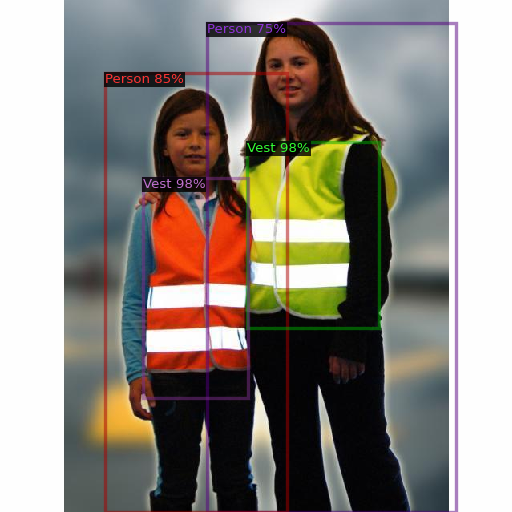

In [10]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/00027_jpg.rf.761d147a0fd78a96a2a9c433f6c3d94c.jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
